# Проведение А/В теста

Сравним две группы, применяя для этого t-критерий.

In [1]:
# импорт библиотек

import pandas as pd
import scipy.stats as st
import pingouin as pg
import seaborn as sns

sns.set(rc={'figure.figsize': (12, 6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Задача:
В очень крупной компании по доставке пиццы есть приложение для курьеров. Также есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

В компании придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Необходимо провести A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. 
Нужно проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

### Описание данных
- order_id - id заказа
- delivery_time - время доставки в минутах
- district - район доставки
- experiment_group - экспериментальная группа

In [2]:
import urllib.parse
import requests

# Загрузка данных
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/uf85TA03-lW-Aw'
 
# Получаем загрузочную ссылку
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href']

# загружаем в датафрейм
ab_test = pd.read_csv(download_url)

In [3]:
ab_test.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


# 1

Сопоставим графики распределения контрольной и  тестовой группы:

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

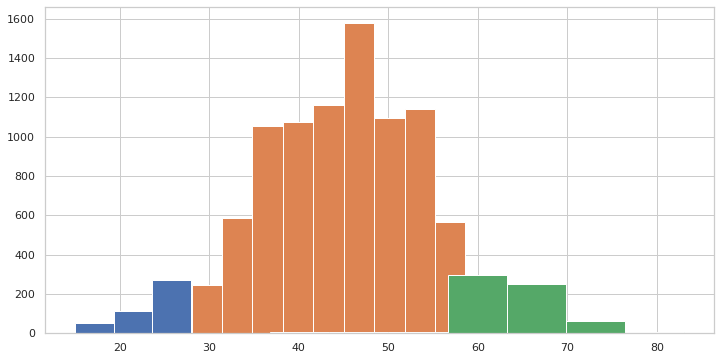

In [4]:
# построим график распределения контрольной группы
ab_test.query("experiment_group == 'control'").groupby("district") \
       .delivery_time.hist()

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

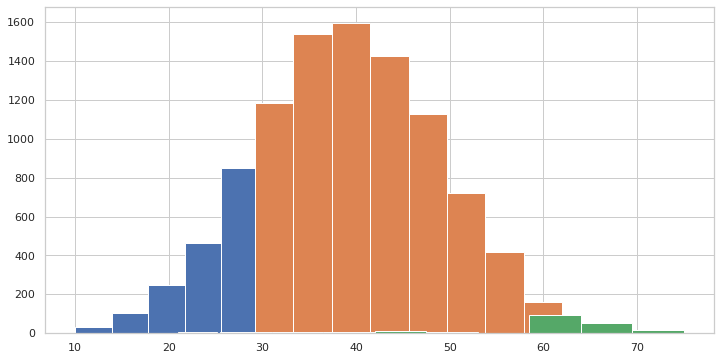

In [5]:
# построим график распределения тестовой группы
ab_test.query("experiment_group == 'test'").groupby("district") \
       .delivery_time.hist()

# 2

Посчитаем количество наблюдений в контрольной и тестовой группе.

In [6]:
# посчитаем количество наблюдений в контрольной и тестовой группе
ab_test.groupby("experiment_group").size()

experiment_group
control    10092
test       10104
dtype: int64

In [7]:
# найдем разницу в количестве наблюдений
10104 - 10092

12

# 3

Изучим распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в контрольной и тестовой группах. Вообще для выборок таких колоссальных размеров это можно не делать - в отсутствие слишком уж выраженной асимметрии и выбросов в данных t-тест и так работать будет нормально.

In [8]:
# посчитаем стандартное отклонение в контрольной и тестовой группах
ab_test.groupby("experiment_group").delivery_time.std()

experiment_group
control    9.990017
test       9.883308
Name: delivery_time, dtype: float64

Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому применим тест Агостино-Пирсона.

In [9]:
# применим тест Агостино-Пирсона для проверки на нормальность
pg.normality(
    data=ab_test,
    dv="delivery_time",
    group="experiment_group",
    method="normaltest"
)

,W,pval,normal
control,0.253498,0.880955,True
test,7.024157,0.029835,False


Тест показывает, что значения в тестовой группе распределены ненормально, а в контрольной группе распределение является 
нормальным.

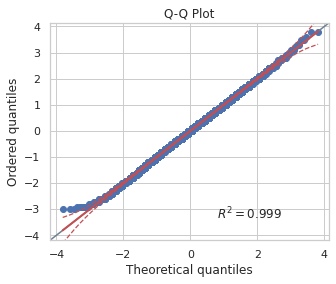

In [10]:
# построим график qq-плот для визуализации
# контрольная группа
pg.qqplot(ab_test.query("experiment_group == 'control'").delivery_time)

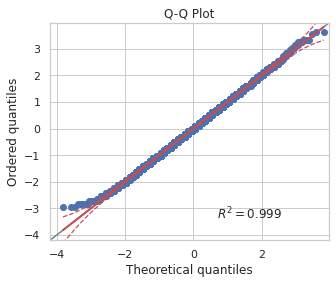

In [11]:
# тестовая группа
pg.qqplot(ab_test.query("experiment_group == 'test'").delivery_time)

Судя по графикам, можно сказать, что распределения в контрольной и тестовой группах очень близко к нормальному, но не является идеально нормальным.
Большинство синих точек расположены очень близко к красной пунктирной линии. Значение R^2=0.999 подтверждает, что данные тесно соответствуют теоретическому нормальному распределению.
Но есть отклонения на "хвостах" распределения, это означает, что в данных есть некоторые экстремальные значения, которые немного отличаются от того, что ожидается в идеальном нормальном распределении.  
**Вывод:**  
Для большинства практических целей и статистических тестов, которые требуют нормальности, это распределение можно считать достаточно нормальным.

# 4

Проведем t-test с поправкой Уэлча, так как стандартные отклонения в контрольной и тестовой группах различаются.

Сформулируем гипотезы для проверки:  
- Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет.  
- Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть.

In [12]:
st.ttest_ind(a=ab_test.query("experiment_group == 'test'").delivery_time,
             b=ab_test.query("experiment_group == 'control'").delivery_time, \
             equal_var=True)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

P-значение < 0.05 (уровень значимости 0,05): Отклоняем нулевую гипотезу. Разница между средним временем доставки в тестовой и контрольной группе является статистически значимой.

# 5

Посчитаем на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной.

In [13]:
# найдем среднее время
mean_test = ab_test.query("experiment_group == 'test'") \
                   .delivery_time.mean()

mean_control = ab_test.query("experiment_group == 'control'") \
                      .delivery_time.mean()

In [14]:
mean_diff = ((mean_test - mean_control) / mean_control) * 100
print(f'Среднее время в тестовой группе меньше, чем в контрольной на: {abs(mean_diff): .2f}%')

Среднее время в тестовой группе меньше, чем в контрольной на:  13.35%


# Итоги:

Раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тестовой группе меньше, чем в контрольной на 13%.